# Action Recognition with an Inflated 3D CNN
The tutorial code at the beginning of this notebook uses the [i3d-kinetics-400](https://www.kaggle.com/models/deepmind/i3d-kinetics/tensorFlow1/400/1?tfhub-redirect=true) module, which is a I3D model pre-trained on the kinetics-400 dateset. We first use I3D to make predictions on the UCF101 Dataset, and later use it to predict the activities in our video dataset without additional training. The goal of this exploration is to determine the extent to which models trained on common human activities generalize to a specific medical context. 

Since the kinetics-400 dateset does not appear to feature activities directly related to the type of clinical setting featured in our dataset, the predictions at the end of this notebook are mostly irrelevant to the actual activities in our videos. However, some of the predictions are similar to the activities in our videos. For example, _making bed_ is relevant to our dataset generally, but is not a particularly useful prediction.  

Nonetheless, the structure provided in this exploration offers a blueprint for implementing a pretrained 3D CNN, which is a model architecture that shows promise for the activities we attempted to predict. This could be useful for future transfer learning or ensemble learning efforts that seek to customize these models and improve prediction accuracy. 

**References**

- Tutorial: https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
- UCF101 Dataset: https://www.kaggle.com/datasets/matthewjansen/ucf101-action-recognition

In [1]:
# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow_docs.vis import embed

logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
# Utilities to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()
# As of July 2020, crcv.ucf.edu doesn't use a certificate accepted by the
# default Colab environment anymore.
unverified_context = ssl._create_unverified_context()


def list_ucf_videos():
  """Lists videos available in UCF101 dataset."""
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8")
    videos = re.findall("(v_[\w_]+\.avi)", index)
    _VIDEO_LIST = sorted(set(videos))
  return list(_VIDEO_LIST)


def fetch_ucf_video(video):
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video)
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video)
    print("Fetching %s => %s" % (urlpath, cache_path))
    data = request.urlopen(urlpath, context=unverified_context).read()
    open(cache_path, "wb").write(data)
  return cache_path


# Utilities to open video files using CV2
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]


def load_video(path, max_frames=0, resize=(224, 224)):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while cap.isOpened():
      ret, frame = cap.read()
      if not ret:
        break

      frame = crop_center_square(frame)
      frame = cv2.resize(frame, resize)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break

    cap.release()

    if len(frames) < max_frames:
        return None
    
  except Exception as e:
     print(e)
      
  return np.array(frames) / 255.0


def video_to_frames(video_path, img_size, sequence_length):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frames.append(frame)
        if len(frames) == sequence_length:
            break
    cap.release()

    if len(frames) < sequence_length:
        return None  # Ignore short videos

    return np.array(frames)



def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  gif = imageio.mimsave('./animation.gif', converted_images, duration=40)
  return gif


<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:15: SyntaxWarning: invalid escape sequence '\w'
C:\Users\lsm0147\AppData\Local\Temp\ipykernel_15792\3610636337.py:15: SyntaxWarning: invalid escape sequence '\w'
  videos = re.findall("(v_[\w_]+\.avi)", index)


In [3]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"

with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
  
print("Found %d labels." % len(labels))


Found 400 labels.


In [4]:
# List files and ignore .DS_Store if on a Mac
def list_files(directory):
    visible_files = []
    for file in os.listdir(directory):
        if not file.startswith('.'):
            visible_files.append(file)

    return visible_files

## Get dataset and categorize videos
Tutorial code modified here since the URL provided by the TensorFlow docs throws a 403 error

In [5]:
# Load i3d-kinetics-400 model
i3d = hub.load("https://tfhub.dev/deepmind/i3d-kinetics-400/1").signatures['default']

In [6]:
def predict(sample_video, print_pred=True):
  # Add a batch axis to the sample video.
  model_input = tf.constant(sample_video, dtype=tf.float32)[tf.newaxis, ...]

  logits = i3d(model_input)['default'][0]
  #probabilities = tf.nn.softmax(logits)

  #Make sure we're cleaning up memory
  del model_input

  return logits

## Predict an activity from our dataset

In [7]:
#label = "Talking on the Phone"
#video = "7393824945081732241_s_1.mp4"
#dir = f"../../downloads/fr_10s"
#video_path = f"../../downloads/fr_10s/test_fr_10s/{label}/{video}"

# Load video
#sample_video = load_video(video_path)
#print("Shape:", sample_video.shape)

# Show a frame from the video for reference
#gif = to_gif(sample_video)
#img = np.asarray(Image.open("./animation.gif").convert('RGB'))
#imgplot = plt.imshow(img)

#plt.show()

#pred = predict(sample_video)

#print(pred)

In [8]:
# Get paths and labels
def load_dataset(folder_path, print_path=False):
    # classes = os.listdir(folder_path)
    classes = list_files(folder_path)
    paths, true_labels, activities = [], [], []

    for label, activity in enumerate(classes):
        activity_folder = os.path.join(folder_path, activity)
        files = list_files(activity_folder)
        num_files = len(files)
        current = 1
        for video_file in files:
            video_path = os.path.join(activity_folder, video_file)
            paths.append(video_path)
            true_labels.append(label)
            activities.append(activity)

            if print_path:
                print(f'{current}/{num_files}\t{video_path}')

            current += 1

    return paths, true_labels, activities


## Predict activities from all videos in our dataset

In [24]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

# Assuming load_dataset, load_video, and predict functions are defined elsewhere
def load_folder_of_videos(path = f"../../downloads/fr_10s/train_fr_10s"):
    # Predict videos from each class of dataset
    #It's alright that we don't use `true_labels`, because we use `activities`
    paths, true_labels, activities = load_dataset(path)

    def process_video(p):
        index, video_path = p
        sample_video = load_video(video_path)
        pred = predict(sample_video, print_pred=False)
        del sample_video
        return [pred, activities[index], video_path]

    # Use ThreadPoolExecutor to parallelize the video processing and tqdm for progress tracking
    with ThreadPoolExecutor(max_workers=2) as executor:
        all_predictions = list(tqdm(executor.map(process_video, enumerate(paths)), total=len(paths)))

    #all_predictions is [
    #    [tf.tensor (output of i3d), class, path]
    #    ...
    #]
    return all_predictions
train_data = load_folder_of_videos(f"../../downloads/fr_10s/train_fr_10s")

In [26]:
def unzip_data(loaded_videos_data):
    data, labels, throwaway = zip(*loaded_videos_data)
    del throwaway
    return (data, labels)
data, labels = unzip_data(train_data)
data

(<tf.Tensor: shape=(400,), dtype=float32, numpy=
 array([ 1.44725302e-02,  5.27685702e-01,  2.20174313e+00, -1.02745259e+00,
         4.61606455e+00, -2.37742019e+00,  2.50330478e-01,  1.79281652e+00,
        -1.72616947e+00, -1.46845663e+00,  2.63208556e+00, -2.24980488e-01,
         2.46677613e+00,  3.95530057e+00,  6.90370023e-01, -2.45954585e+00,
         2.46542692e+00, -5.40227711e-01,  2.58030057e+00,  9.86548066e-02,
         2.35923648e+00,  6.75252452e-02,  6.96746930e-02,  2.98652363e+00,
        -2.40783787e+00, -3.22833705e+00,  5.02225256e+00, -2.16476369e+00,
         6.72302067e-01, -7.43111134e-01, -1.30640233e+00, -1.96255460e-01,
         1.87655509e+00,  6.49245441e-01, -3.81402932e-02,  1.83115900e+00,
        -8.29294443e-01,  1.58786690e+00, -1.85867131e+00, -2.19392180e+00,
        -1.93020785e+00, -2.17844868e+00, -1.46173513e+00,  2.91712761e+00,
         1.72966325e+00, -1.65242970e+00, -3.05425283e-02, -2.14241385e-01,
        -1.49848366e+00, -2.79908568e-0

c:\Users\lsm0147\Documents\activity-recog\model_types\inflated_3d\.venv\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


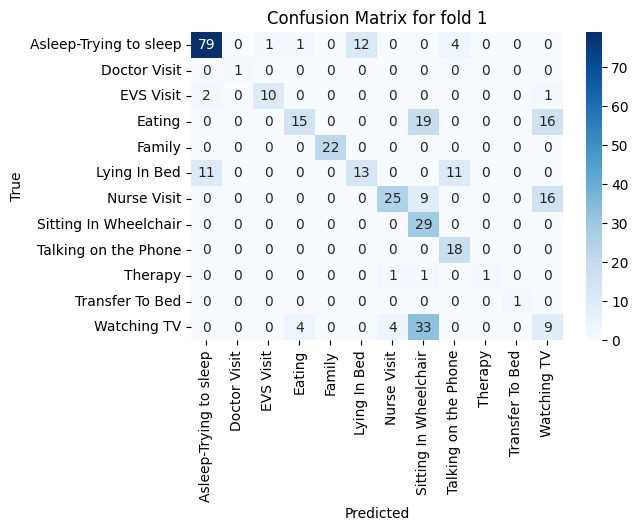

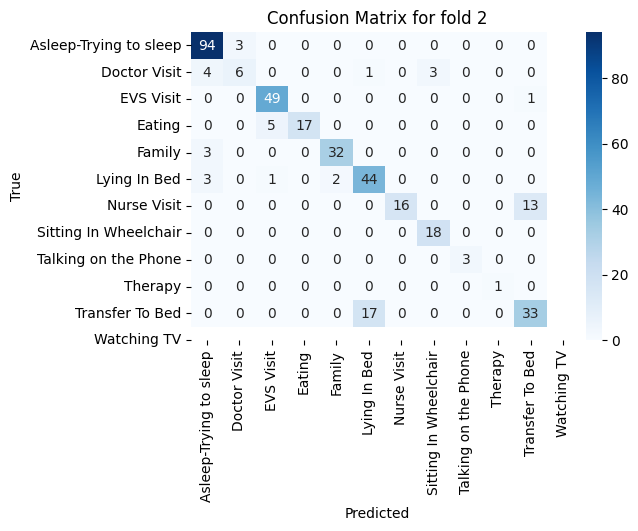

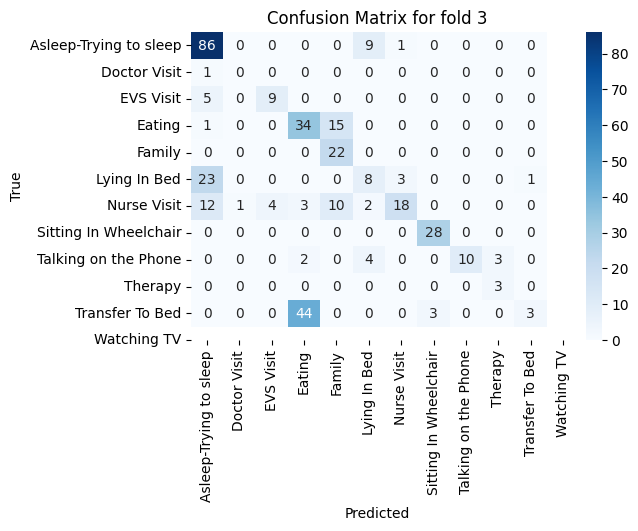

Cross-validated accuracies: [0.6043360433604336, 0.8482384823848238, 0.6005434782608695]
Mean accuracy: 0.6844


In [29]:
#Really fast cross validation before we do our holdout set
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the data
flattened_data = [tf.reshape(tensor, [-1]).numpy() for tensor in data]

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

# Convert to numpy arrays
flattened_data = np.array(flattened_data)
numerical_labels = np.array(numerical_labels)

# Stratified cross-validation
skf = StratifiedKFold(n_splits=3)
accuracies = []
conf_matrices = []

for train_index, test_index in skf.split(flattened_data, numerical_labels):
    train_data, test_data = flattened_data[train_index], flattened_data[test_index]
    train_labels, test_labels = numerical_labels[train_index], numerical_labels[test_index]

    # Create and train the SVM model
    svm_model = SVC(kernel='linear')
    svm_model.fit(train_data, train_labels)

    # Predict and evaluate the model
    predictions = svm_model.predict(test_data)
    accuracy = accuracy_score(test_labels, predictions)
    accuracies.append(accuracy)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(test_labels, predictions)
    conf_matrices.append(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for fold {len(accuracies)}')
    plt.show()

print(f'Cross-validated accuracies: {accuracies}')
print(f'Mean accuracy: {np.mean(accuracies):.4f}')


In [ ]:
del data
del labels

train_data, train_labels = unzip_data(train_data)
flattened_train_data = [tf.reshape(tensor, [-1]).numpy() for tensor in train_data]

#test_data = train_data #If you're lazy, or if you like to see something with 100% accuracy
test_data = load_folder_of_videos(f"../../downloads/fr_10s/test_fr_10s")

test_data, test_labels = unzip_data(train_data)
flattened_test_data = [tf.reshape(tensor, [-1]).numpy() for tensor in test_data]

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use LabelEncoder to convert string labels to numerical labels
label_encoder = LabelEncoder()
numerical_train_labels = label_encoder.fit_transform(train_labels)
numerical_test_labels = label_encoder.transform(test_labels)

# Convert to numpy arrays
flattened_train_data = np.array(flattened_train_data)
numerical_train_labels = np.array(numerical_train_labels)
flattened_test_data = np.array(flattened_test_data)
numerical_test_labels = np.array(numerical_test_labels)

# Create and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(flattened_train_data, numerical_train_labels)

# Predict and evaluate the model on the holdout test set
predictions = svm_model.predict(flattened_test_data)
accuracy = accuracy_score(numerical_test_labels, predictions)
conf_matrix = confusion_matrix(numerical_test_labels, predictions)

# Print the accuracy
print(f'Test accuracy: {accuracy:.4f}')

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Holdout Test Set')
plt.show()